In [1]:
import os
file_path = "../data/IMF.xlsx"
print(os.path.exists(file_path))  # Should return True if the file exists


True


In [2]:
import pandas as pd

# Replace 'b1/your_file.xlsx' with the correct path
file_path = "../data/IMF.xlsx"

# Read the first sheet of the Excel file
df = pd.read_excel(file_path, engine="openpyxl")  

# Display the first few rows
print(df)


  International Financial Statistics (IFS)  \
0                                      NaN   
1                                   France   
2                                   France   
3                                   France   
4                                   France   
5                            United States   
6                            United States   
7                            United States   
8                            United States   

                                          Unnamed: 1    Unnamed: 2 Unnamed: 3  \
0                                                NaN   1959.000000   Dec 1959   
1    Economic Activity, Industrial Production, Index     32.250545  35.365725   
2  Exchange Rates, National Currency Per U.S. Dol...      4.937060    4.93706   
3  International Reserves and Liquidity, Reserves...   1735.740000    1735.74   
4     Prices, Consumer Price Index, All items, Index     10.018821  10.208981   
5    Economic Activity, Industrial Production, Index 

In [3]:
print(df.info())  # Get data types and non-null counts
print(df.columns)  # Show column names


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Columns: 407 entries, International Financial Statistics (IFS) to Unnamed: 406
dtypes: float64(32), object(375)
memory usage: 28.7+ KB
None
Index(['International Financial Statistics (IFS)', 'Unnamed: 1', 'Unnamed: 2',
       'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7',
       'Unnamed: 8', 'Unnamed: 9',
       ...
       'Unnamed: 397', 'Unnamed: 398', 'Unnamed: 399', 'Unnamed: 400',
       'Unnamed: 401', 'Unnamed: 402', 'Unnamed: 403', 'Unnamed: 404',
       'Unnamed: 405', 'Unnamed: 406'],
      dtype='object', length=407)


In [4]:
print(df.iloc[:, 0].head(10))  # Print the first 10 rows of the first column


0              NaN
1           France
2           France
3           France
4           France
5    United States
6    United States
7    United States
8    United States
Name: International Financial Statistics (IFS), dtype: object


# construct variable

## monthly growth in the nominal exchange rate

In [5]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find the row index where "Exchange Rates, National Currency Per U.S. Dollar" appears
exchange_rate_row = df[df.iloc[:, 1].str.contains("Exchange Rates", na=False)].index[0]

# Extract the relevant row (France's exchange rate data)
exchange_rate_data = df.iloc[exchange_rate_row, 1:].reset_index(drop=True)

# Convert values to numeric (ignore the first value, which is text)
exchange_rate_data = pd.to_numeric(exchange_rate_data[1:], errors="coerce")

# Drop NaN values
exchange_rate_data.dropna(inplace=True)


In [6]:
# Compute the monthly growth rate in percentage
monthly_growth = exchange_rate_data.pct_change() * 100

# Convert to DataFrame for better visualization
monthly_growth_df = pd.DataFrame({
    "Month": range(1, len(monthly_growth) + 1),
    "Growth (%)": monthly_growth.values
})

# Display the first few rows
print(monthly_growth_df)


     Month  Growth (%)
0        1         NaN
1        2    0.000000
2        3    0.000000
3        4    0.000000
4        5    0.000000
..     ...         ...
400    401   -4.134170
401    402   -0.295841
402    403   -2.900618
403    404   -2.047013
404    405    1.317868

[405 rows x 2 columns]


## real exchange rate

In [7]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices dynamically
exchange_rate_row = df[df.iloc[:, 1].str.contains("Exchange Rates", na=False)].index[0]
france_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract data
exchange_rate = pd.to_numeric(df.iloc[exchange_rate_row, 2:], errors="coerce")
france_cpi = pd.to_numeric(df.iloc[france_cpi_row, 2:], errors="coerce")
us_cpi = pd.to_numeric(df.iloc[us_cpi_row, 2:], errors="coerce")

# Drop NaN values (optional, depending on data quality)
exchange_rate.dropna(inplace=True)
france_cpi.dropna(inplace=True)
us_cpi.dropna(inplace=True)

# Compute Real Exchange Rate (RER)
rer = exchange_rate * (us_cpi / france_cpi)

# Compute Monthly Growth in RER
monthly_growth_rer = rer.pct_change() * 100  # Convert to percentage

# Convert to DataFrame for better visualization
monthly_growth_rer_df = pd.DataFrame({
    "Month": range(1, len(monthly_growth_rer) + 1),
    "Real Exchange Rate Growth (%)": monthly_growth_rer.values
})

# Display the first few rows
print(monthly_growth_rer_df.head())


   Month  Real Exchange Rate Growth (%)
0      1                            NaN
1      2                      -1.021015
2      3                      -1.570361
3      4                      -0.073166
4      5                       0.110462


## An index of the real exchange rate (setting the real exchange rate for December 1990 = 1)

In [8]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Print the first few rows to inspect structure
print(df.head())

# Extract the date row (assuming it's the first row)
date_row = df.iloc[0, 2:].astype(str).str.strip()

# Print unique values to check format
print("\nRaw date row values:\n", date_row.unique())


                                        0    \
0  International Financial Statistics (IFS)   
1                                       NaN   
2                                    France   
3                                    France   
4                                    France   

                                                 1            2          3    \
0                                                NaN          NaN        NaN   
1                                                NaN  1959.000000   Dec 1959   
2    Economic Activity, Industrial Production, Index    32.250545  35.365725   
3  Exchange Rates, National Currency Per U.S. Dol...     4.937060    4.93706   
4  International Reserves and Liquidity, Reserves...  1735.740000    1735.74   

           4          5          6          7          8          9    ...  \
0          NaN        NaN        NaN        NaN        NaN        NaN  ...   
1  1960.000000   Jan 1960   Feb 1960   Mar 1960   Apr 1960   May 1960  ...   
2 

In [9]:
# Try parsing month-year format first
dates = pd.to_datetime(date_row, format="%b %Y", errors="coerce")

# Handle pure year values separately (if parsing failed)
dates.loc[dates.isna()] = pd.to_datetime(date_row.loc[dates.isna()], format="%Y", errors="coerce")

# Print parsed dates
print("\nParsed dates:\n", dates.dropna().unique())



Parsed dates:
 <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]


In [12]:
df = pd.read_excel(file_path, engine="openpyxl", skiprows=1)  # Skip first row

print("Column Headers:", df.columns)


Column Headers: Index(['Unnamed: 0', 'Unnamed: 1', '1959', 'Dec 1959', '1960', 'Jan 1960',
       'Feb 1960', 'Mar 1960', 'Apr 1960', 'May 1960',
       ...
       'Mar 1990', 'Apr 1990', 'May 1990', 'Jun 1990', 'Jul 1990', 'Aug 1990',
       'Sep 1990', 'Oct 1990', 'Nov 1990', 'Dec 1990'],
      dtype='object', length=407)


In [13]:
# Identify columns that are four-digit years
year_only_columns = df.columns[2:][df.columns[2:].astype(str).str.match(r"^\d{4}$")]

# Drop these columns
df_cleaned = df.drop(columns=year_only_columns)

In [ ]:
# Load data (skipping first row)
df = pd.read_excel(file_path, engine="openpyxl", skiprows=1)

# Extract only potential date columns (excluding the first two columns)
raw_date_headers = df.columns[2:]  # Ignore first two non-date columns

# Filter out standalone years (keep only "Month Year" format)
filtered_dates = [col for col in raw_date_headers if not col.isdigit()]  # Remove pure years

# Convert the filtered date headers to datetime
dates = pd.to_datetime(filtered_dates, format="%b %Y", errors="coerce")

# Debug: Check parsed dates
print("Parsed Dates:", dates)

# ✅ FIX: Remove .dt from DatetimeIndex
dec_1990_index = (dates.year == 1990) & (dates.month == 12)

if dec_1990_index.sum() == 0:
    raise ValueError(f"December 1990 not found! Check the parsed dates: {dates}")

print("December 1990 found at index:", dec_1990_index.argmax())


Parsed Dates: DatetimeIndex(['1959-12-01', '1960-01-01', '1960-02-01', '1960-03-01',
               '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01',
               '1960-08-01', '1960-09-01',
               ...
               '1990-03-01', '1990-04-01', '1990-05-01', '1990-06-01',
               '1990-07-01', '1990-08-01', '1990-09-01', '1990-10-01',
               '1990-11-01', '1990-12-01'],
              dtype='datetime64[ns]', length=373, freq=None)
December 1990 found at index: 372


In [15]:
# Extract the real exchange rate (RER) series
rer_series = rer.values  # Assuming `rer` is already computed

# Get RER value for December 1990
rer_dec_1990 = rer_series[372]

# Normalize the RER series to set Dec 1990 = 1
rer_index = rer_series / rer_dec_1990


In [17]:
rer_series = rer_series[:len(dates)]


In [18]:
print(f"Length of dates: {len(dates)}")
print(f"Length of rer_series: {len(rer_series)}")


Length of dates: 373
Length of rer_series: 373


In [19]:
rer_index_df = pd.DataFrame({
    "Date": dates,  
    "RER Index": rer_series
})


In [20]:
print(rer_index_df.head())

        Date  RER Index
0 1959-12-01   6.587541
1 1960-01-01   6.520281
2 1960-02-01   6.417889
3 1960-03-01   6.413193
4 1960-04-01   6.420277


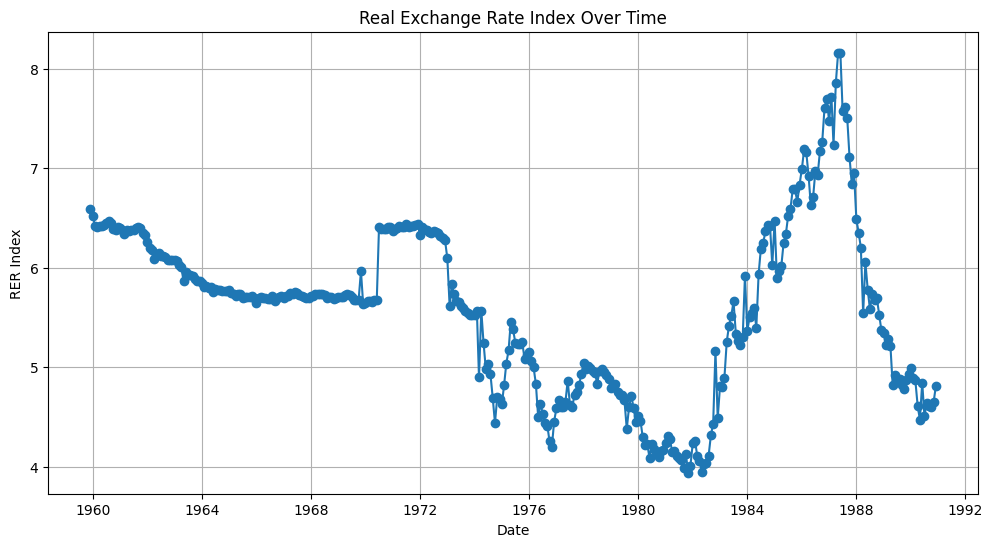

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(rer_index_df["Date"], rer_index_df["RER Index"], marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("RER Index")
plt.title("Real Exchange Rate Index Over Time")
plt.grid()
plt.show()


## monthly inflation rate

In [23]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and US CPI dynamically
france_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract CPI data
france_cpi = pd.to_numeric(df.iloc[france_cpi_row, 2:], errors="coerce")
us_cpi = pd.to_numeric(df.iloc[us_cpi_row, 2:], errors="coerce")

# Compute Monthly Inflation Rate (percentage change)
france_inflation = france_cpi.pct_change() * 100
us_inflation = us_cpi.pct_change() * 100

# Create DataFrame for visualization
inflation_df = pd.DataFrame({
    "Month": range(1, len(france_inflation) + 1),
    "France Inflation (%)": france_inflation.values,
    "US Inflation (%)": us_inflation.values
})

# Display first few rows
print(inflation_df)


     Month  France Inflation (%)  US Inflation (%)
0        1                   NaN               NaN
1        2              1.898027          0.857633
2        3              2.200149          0.595238
3        4             -0.857301         -0.929839
4        5              0.230580          0.341297
..     ...                   ...               ...
400    401              0.654762          0.920245
401    402              0.709639          0.835866
402    403              0.440399          0.602864
403    404             -0.160772          0.224719
404    405             -0.073196          0.000000

[405 rows x 3 columns]


## The monthly growth in industrial production

In [26]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and US Industrial Production dynamically
france_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract Industrial Production Index data
france_ip = pd.to_numeric(df.iloc[france_ip_row, 2:], errors="coerce")
us_ip = pd.to_numeric(df.iloc[us_ip_row, 2:], errors="coerce")

# Compute Monthly Growth in Industrial Production (percentage change)
france_ip_growth = france_ip.pct_change() * 100
us_ip_growth = us_ip.pct_change() * 100

# Create DataFrame for visualization
industrial_production_df = pd.DataFrame({
    "Month": range(1, len(france_ip_growth) + 1),
    "France IP Growth (%)": france_ip_growth.values,
    "US IP Growth (%)": us_ip_growth.values
})

# Display first few rows
print(industrial_production_df)


     Month  France IP Growth (%)  US IP Growth (%)
0        1                   NaN               NaN
1        2              9.659310          1.623282
2        3             -0.547048          0.585603
3        4             -3.340705          2.318054
4        5              2.343046          0.560316
..     ...                   ...               ...
400    401            -25.892857          3.346457
401    402             38.855422          0.761905
402    403             10.195228         -1.348456
403    404             -5.216535         -2.593255
404    405             -4.880582         -1.468852

[405 rows x 3 columns]


## The growth in industrial production versus 12 months ago (i.e. January 1971 versus January 1970 etc.)


In [28]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and US Industrial Production dynamically
france_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract Industrial Production Index data
france_ip = pd.to_numeric(df.iloc[france_ip_row, 2:], errors="coerce")
us_ip = pd.to_numeric(df.iloc[us_ip_row, 2:], errors="coerce")

# Compute Year-over-Year (YoY) Growth in Industrial Production
france_ip_yoy_growth = france_ip.pct_change(periods=12) * 100
us_ip_yoy_growth = us_ip.pct_change(periods=12) * 100

# Create DataFrame for visualization
industrial_production_yoy_df = pd.DataFrame({
    "Month": range(1, len(france_ip_yoy_growth) + 1),
    "France YoY IP Growth (%)": france_ip_yoy_growth.values,
    "US YoY IP Growth (%)": us_ip_yoy_growth.values
})

# Display first few rows
print(industrial_production_yoy_df)


     Month  France YoY IP Growth (%)  US YoY IP Growth (%)
0        1                       NaN                   NaN
1        2                       NaN                   NaN
2        3                       NaN                   NaN
3        4                       NaN                   NaN
4        5                       NaN                   NaN
..     ...                       ...                   ...
400    401                -24.512254              1.731043
401    402                 -4.405952              3.159126
402    403                  5.442428              2.972902
403    404                  3.471848              0.144471
404    405                  0.000000             -2.766456

[405 rows x 3 columns]


## An index of the value of international reserves (value of reserves for January 1960 = 100)

In [30]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and U.S. International Reserves
france_reserves_row = df[(df.iloc[:, 1].str.contains("International Reserves", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_reserves_row = df[(df.iloc[:, 1].str.contains("International Reserves", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract International Reserves data
france_reserves = pd.to_numeric(df.iloc[france_reserves_row, 2:], errors="coerce")
us_reserves = pd.to_numeric(df.iloc[us_reserves_row, 2:], errors="coerce")

# Find the value of reserves in January 1960 (assumes the first column is Jan 1960)
jan_1960_index = 2  # Assuming the first data column corresponds to Jan 1960
france_reserves_jan_1960 = france_reserves.iloc[jan_1960_index]
us_reserves_jan_1960 = us_reserves.iloc[jan_1960_index]

# Construct the Index (Normalize to Jan 1960 = 100)
france_reserves_index = (france_reserves / france_reserves_jan_1960) * 100
us_reserves_index = (us_reserves / us_reserves_jan_1960) * 100

# Create DataFrame for visualization
reserves_index_df = pd.DataFrame({
    "Month": range(1, len(france_reserves_index) + 1),
    "France Reserves Index": france_reserves_index.values,
    "US Reserves Index": us_reserves_index.values
})

# Display first few rows
print(reserves_index_df)


     Month  France Reserves Index  US Reserves Index
0        1              76.400033         111.083848
1        2              76.400033         111.083848
2        3             100.000000         100.000000
3        4              77.192318         110.947476
4        5              79.084999         110.521830
..     ...                    ...                ...
400    401            2593.329233         407.612240
401    402            2736.068163         413.373588
402    403            2841.859716         427.982088
403    404            2928.531908         429.052435
404    405            2997.429925         430.379025

[405 rows x 3 columns]


# US

In [32]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices dynamically
us_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "United States")].index[0]
us_reserves_row = df[(df.iloc[:, 1].str.contains("International Reserves", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract U.S. data
us_cpi = pd.to_numeric(df.iloc[us_cpi_row, 2:], errors="coerce")
us_reserves = pd.to_numeric(df.iloc[us_reserves_row, 2:], errors="coerce")

# (i) Compute Monthly Inflation Rate
us_inflation_rate = us_cpi.pct_change() * 100  # Convert to percentage

# (ii) Compute International Reserves Index (Jan 1960 = 100)
jan_1960_index = 2  # Assuming first data column corresponds to Jan 1960
us_reserves_jan_1960 = us_reserves.iloc[jan_1960_index]
us_reserves_index = (us_reserves / us_reserves_jan_1960) * 100

# Create DataFrame for visualization
us_data_df = pd.DataFrame({
    "Month": range(1, len(us_cpi) + 1),
    "US Inflation Rate (%)": us_inflation_rate.values,
    "US Reserves Index": us_reserves_index.values
})

# Display first few rows
print(us_data_df)


     Month  US Inflation Rate (%)  US Reserves Index
0        1                    NaN         111.083848
1        2               0.857633         111.083848
2        3               0.595238         100.000000
3        4              -0.929839         110.947476
4        5               0.341297         110.521830
..     ...                    ...                ...
400    401               0.920245         407.612240
401    402               0.835866         413.373588
402    403               0.602864         427.982088
403    404               0.224719         429.052435
404    405               0.000000         430.379025

[405 rows x 3 columns]


## Identify outliers

In [ ]:
import pandas as pd
import numpy as np

# Function to detect and replace outliers
def detect_outliers(series, method="IQR"):
    if method == "IQR":
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return series.mask((series < lower_bound) | (series > upper_bound), np.nan)
    
    elif method == "Z-score":
        mean = series.mean()
        std = series.std()
        z_scores = (series - mean) / std
        return series.mask((z_scores < -3) | (z_scores > 3), np.nan)

# Apply outlier detection to each data series
exchange_rate_clean = detect_outliers(exchange_rate)
france_cpi_clean = detect_outliers(france_cpi)
us_cpi_clean = detect_outliers(us_cpi)
industrial_production_clean = detect_outliers(industrial_production)
international_reserves_clean = detect_outliers(international_reserves)
rer_growth_clean = detect_outliers(monthly_growth_rer)
industrial_production_growth_clean = detect_outliers(industrial_production_growth)
industrial_production_12m_clean = detect_outliers(industrial_production_12m)
us_inflation_rate_clean = detect_outliers(us_inflation_rate)

# Create DataFrame for cleaned data
cleaned_data = pd.DataFrame({
    "Exchange Rate": exchange_rate_clean,
    "France CPI": france_cpi_clean,
    "US CPI": us_cpi_clean,
    # "Industrial Production": industrial_production_clean,
    # "International Reserves": international_reserves_clean,
    # "RER Growth (%)": rer_growth_clean,
    # "Industrial Production Growth (%)": industrial_production_growth_clean,
    # "12-Month Industrial Production Growth (%)": industrial_production_12m_clean,
    "US Inflation Rate (%)": us_inflation_rate_clean
})

# Display summary
print(cleaned_data.describe())


       Exchange Rate  France CPI      US CPI  US Inflation Rate (%)
count     359.000000  405.000000  405.000000             351.000000
mean        5.127330   31.939606   29.818304               0.409321
std         0.634909   21.044375   15.477819               0.342825
min         4.004645   10.018821   13.368156              -0.457457
25%         4.911522   13.220356   15.363061               0.218161
50%         4.937060   23.419448   24.580898               0.333890
75%         5.554190   52.313266   45.034406               0.587474
max         6.926900   72.237766   61.360525               1.413882
